<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries-and-load-the-data" data-toc-modified-id="Import-libraries-and-load-the-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries and load the data</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Target-variable" data-toc-modified-id="Target-variable-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Target variable</a></span><ul class="toc-item"><li><span><a href="#Log-Transformation" data-toc-modified-id="Log-Transformation-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Log Transformation</a></span></li></ul></li><li><span><a href="#Encoding-categorical-features" data-toc-modified-id="Encoding-categorical-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Encoding categorical features</a></span></li><li><span><a href="#Train/-Test-Splits" data-toc-modified-id="Train/-Test-Splits-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Train/ Test Splits</a></span></li><li><span><a href="#1.2-Scaler" data-toc-modified-id="1.2-Scaler-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>1.2 Scaler</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Dummy-Regressor" data-toc-modified-id="Dummy-Regressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dummy Regressor</a></span></li><li><span><a href="#R^2---Goodness-of-Fit" data-toc-modified-id="R^2---Goodness-of-Fit-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>R^2 - Goodness of Fit</a></span></li><li><span><a href="#Multiple-Linear-Regression" data-toc-modified-id="Multiple-Linear-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Multiple Linear Regression</a></span><ul class="toc-item"><li><span><a href="#What-Log-Transformations-Really-Mean?" data-toc-modified-id="What-Log-Transformations-Really-Mean?-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>What Log Transformations Really Mean?</a></span></li><li><span><a href="#Interpreting-coefficients" data-toc-modified-id="Interpreting-coefficients-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Interpreting coefficients</a></span></li></ul></li><li><span><a href="#Ordinary-Least-Squares-(OLS)" data-toc-modified-id="Ordinary-Least-Squares-(OLS)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Ordinary Least Squares (OLS)</a></span></li><li><span><a href="#Lasso-L1-Norm-Regression" data-toc-modified-id="Lasso-L1-Norm-Regression-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Lasso L1 Norm Regression</a></span></li><li><span><a href="#Ridge-L2-norm-regression" data-toc-modified-id="Ridge-L2-norm-regression-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Ridge L2 norm regression</a></span></li><li><span><a href="#Random-Forest-Regressor" data-toc-modified-id="Random-Forest-Regressor-3.7"><span class="toc-item-num">3.7&nbsp;&nbsp;</span>Random Forest Regressor</a></span></li></ul></li><li><span><a href="#Summary-and-further-analysis" data-toc-modified-id="Summary-and-further-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Summary and further analysis</a></span></li></ul></div>

In this project, I will train and test regression models on superstore's sales data and then evaluate the performance and predictive power of models. 

## Import libraries and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_score, ShuffleSplit
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, Ridge, RidgeCV, ElasticNet, ElasticNetCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm 

from scipy.stats import norm, probplot
from sklearn import __version__ as sklearn_version
from library.sb_utils import save_file
%matplotlib inline
sns.set_style('whitegrid') 

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Data/clean_data.csv')
df.head(3)

,ShipMode,Segment,City,State,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Months,Year,zip_rank
0,Second Class,Corporate,Los Angeles,California,West,Office Supplies,Labels,14.620,2,0.0,6.8714,6,2016,295
1,Standard Class,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,22.368,2,0.2,2.5164,10,2015,274
2,Standard Class,Consumer,Los Angeles,California,West,Furniture,Furnishings,48.860,7,0.0,14.1694,6,2014,292


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5916 entries, 0 to 5915
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ShipMode      5916 non-null   object 
 1   Segment       5916 non-null   object 
 2   City          5916 non-null   object 
 3   State         5916 non-null   object 
 4   Region        5916 non-null   object 
 5   Category      5916 non-null   object 
 6   Sub-Category  5916 non-null   object 
 7   Sales         5916 non-null   float64
 8   Quantity      5916 non-null   int64  
 9   Discount      5916 non-null   float64
 10  Profit        5916 non-null   float64
 11  Months        5916 non-null   int64  
 12  Year          5916 non-null   int64  
 13  zip_rank      5916 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 647.2+ KB


## Data Preprocessing

In [4]:
df_num = df.select_dtypes(include=['int64', 'float64'])

In [5]:
df_num.head()

,Sales,Quantity,Discount,Profit,Months,Year,zip_rank
0,14.620,2,0.0,6.8714,6,2016,295
1,22.368,2,0.2,2.5164,10,2015,274
2,48.860,7,0.0,14.1694,6,2014,292
3,7.280,4,0.0,1.9656,6,2014,292
4,18.504,3,0.2,5.7825,6,2014,292


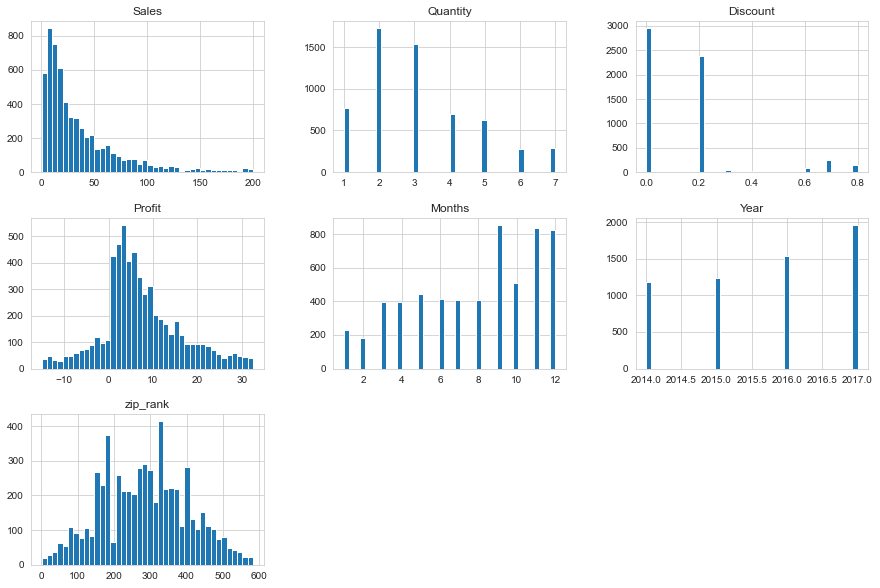

In [6]:
# sns.pairplot() output a figure containing histogram and scatter plot between each variable
# sns.set_palette('Set2')
# sns.pairplot(data=df, height=3);
df.hist(figsize=(15,10), bins=40);

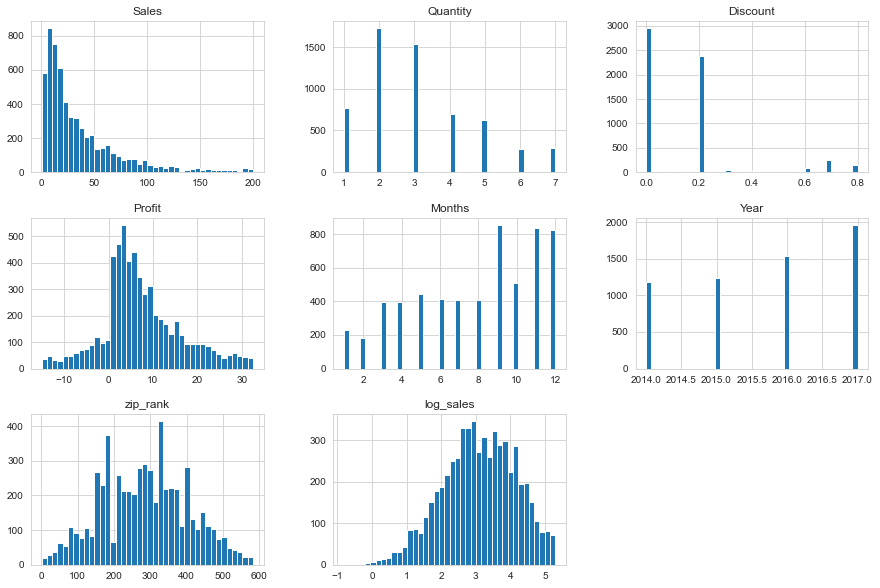

In [7]:
df['log_sales'] = np.log(df['Sales'])
df.hist(figsize=(15,10), bins=40);

### Target variable 

Skewness: 1.908324
Kurtosis: 3.884247


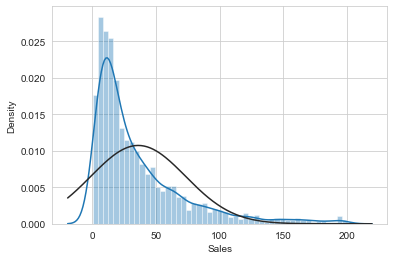

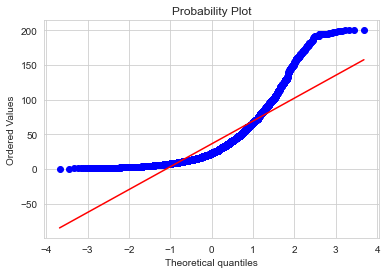

In [8]:
#histogram of sales of all states and normal probability plot

sns.distplot(df['Sales'], fit=norm);
fig = plt.figure()
res = probplot(df['Sales'], plot=plt)
plt.savefig('images/target.png')

print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

# 'Sales' is skewed to the right due to West Virginia, Vermont, District of Columbia and a few others.

#### Log Transformation

Log transformations are often recommended for skewed data, such as monetary measures. Log transforming data has the effect of spreading out clumps of data and bringing together spread-out data.

After a log transformation of 'Sales', the histogram is more or less symmetric. I’ve moved the bigger states sales closer together and spaced out the smaller states sales.

One reason is to make data more “normal”, or symmetric because it could help meet the assumption of constant variance in the context of linear modeling. Yet another reason is to help make a non-linear relationship more linear. But while it’s easy to implement a log transformation, it can complicate interpretation. Let’s say we fit a linear model with a log-transformed dependent variable - 'Sales'. How do we interpret the coefficients?


#histogram and normal probability plot
sns.distplot(df['sales_log'], fit=norm);
fig = plt.figure()
res = probplot(df['sales_log'], plot=plt)

print("Skewness: %f" % df['sales_log'].skew())
print("Kurtosis: %f" % df['sales_log'].kurt())

### Encoding categorical features

In [9]:
df['Months'] = df.Months.astype('category')
#df['Category'] = df.Category.astype('category')

In [10]:
# Categorical to Quantitative relationship
categorical_features = [i for i in df.columns if (df.dtypes[i] == "object") or (df.dtypes[i] == "category")]
categorical_features

['ShipMode',
 'Segment',
 'City',
 'State',
 'Region',
 'Category',
 'Sub-Category',
 'Months']

In [11]:
# labeling encoding the categorical features
# categorical_features = ['Segment', 'Category', 'Sub-Category', 'Months']
for cat in categorical_features:
    label = LabelEncoder()
    df[cat] = label.fit_transform(df[cat])

df[cat].dropna(inplace=True)

In [12]:
df = df.dropna()

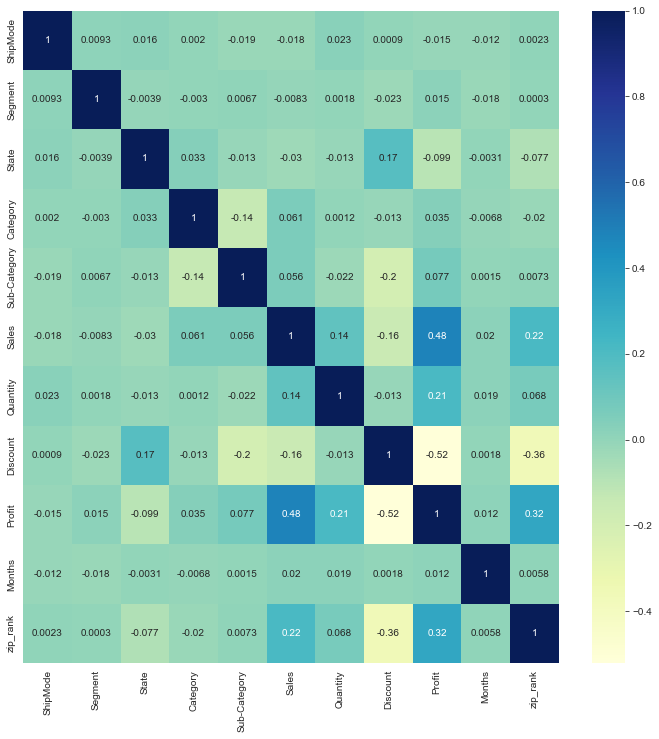

In [13]:
corr = df.drop(['Year', 'Region', 'City', 'log_sales'], axis=1).corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr, annot=True,cmap="YlGnBu");

In [14]:
c = corr.abs().unstack().drop_duplicates().reset_index()
c = c.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Correlation'})
c = c.query('.2 <= Correlation < 1').sort_values(by = 'Correlation', ascending = False).reset_index(drop=True)
c.style.background_gradient(cmap='Set1_r')

,feature 1,feature 2,Correlation
0,Discount,Profit,0.520424
1,Sales,Profit,0.481422
2,Discount,zip_rank,0.361715
3,Profit,zip_rank,0.321702
4,Sales,zip_rank,0.215549
5,Quantity,Profit,0.212552


Based on the cross correlation coefficients, I would expect the following:

- **'Quantity'** has a positive correlation with the sales.

- **'Postal code'**: In the densely **populated states or postal codes** in the west and east regions, the sales is high. As most of sales came from the category of 'Technology', this fact could be interpreted as more university students and more tech related residents in that region. The attractive higher education system and companies lead to a fact for high demand of the tech-related products. Hence, the sales would increase.

- **'Discount'** has a strong negative correlation with 'Sales' and also with 'zip_rank'

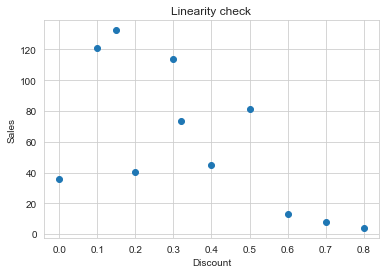

In [15]:
discount_sales = df.groupby('Discount')['Sales'].mean()

plt.scatter(discount_sales.index, discount_sales)
plt.title("Linearity check")
plt.xlabel('Discount')
plt.ylabel('Sales')
plt.show();
# on average per discount looks not linear

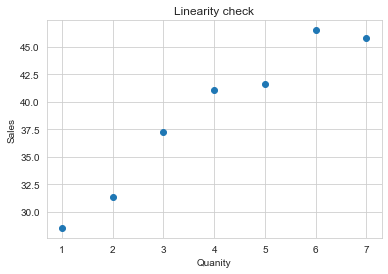

In [16]:
quantity_sales = df.groupby('Quantity')['Sales'].mean()

plt.scatter(quantity_sales.index, quantity_sales)
plt.title("Linearity check")
plt.xlabel('Quanity')
plt.ylabel('Sales')
plt.show();
# on average per quantity looks linear

In [17]:
q1 = df['zip_rank'].quantile(0.25)
q3 = df['zip_rank'].quantile(0.75)
IQR = q3 - q1

filter = (df['zip_rank'] >= q1 -1.5 *IQR) & (df['zip_rank'] <= q3 + 1 *IQR)
df = df.loc[filter]
df.shape

(5867, 15)

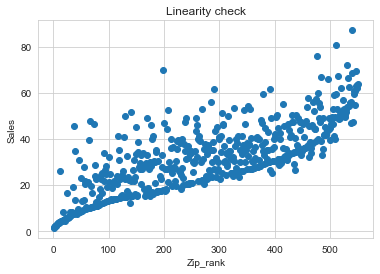

In [18]:
zip_sales = df.groupby('zip_rank')['Sales'].mean()

plt.scatter(zip_sales.index, zip_sales)
plt.title("Linearity check")
plt.xlabel('Zip_rank')
plt.ylabel('Sales')
plt.show();

### Train/ Test Splits

In order to fit the models on the data, I first define the ‘X’ variable (independent variable) and the ‘Y’ variable (dependent variable). After defining the variables, split the data into a train set and test set using the ‘train_test_split’ function by scikit-learn. 

In [19]:
# y = sales 
# 𝑋  = all the other features (or independent variables, predictors or explanatory variables) 
# use to fit a linear regression model and predict
# X = df.drop(['sales_log', 'Sales', 'Year', 'Profit', 'Region', 'City'], axis=1)
X = df.drop(['log_sales', 'Sales', 'Year','Segment', 'City', 'Region',  'Months'], axis=1)
y = df['Sales']

In [20]:
# Training set: is a subset of the dataset used to build and fit predictive models
# test set used for evaluation purposes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
print(X_train.shape, X_test.shape)

(4693, 8) (1174, 8)


### 1.2 Scaler

Data standardization is useful when you want to compare data that correspond to different units.

In [21]:
#Call StandardScaler method on `X_tr` to fit the scaler;
# use `transform()` method to apply the scaling to both the train and test split.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling

To build and train five different types of linear regression models:
    - OLS model
    - Lasso regression model
    - Ridge regression model
    - Elastic Net regression model
    - Random forest regression model
    
    The linear regression model assumes a linear relationship between the input and output variables. If this relationship is present, we use Pearson correlation coefficients to measure the direction and strength of the linear relationship between target variable and predictor variables, and use evaluation metrics such as R^2 and mean square error to measure the predictive power of the linear regression model. 

### Dummy Regressor

The most basic understanding of the dependent variable 'sales' is a measure of central tendency. Calculate the mean of 'Sales' is considered as a baseline model because there is no assumptions about the distribution of the data or its dependencies on any other data. 

In [22]:
# gain a baseline idea that the average sales  of the data is $35.5
train_mean = y_train.mean()
train_mean

35.510683145109624

In [23]:
# Fit the skilearn dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
print(dumb_reg.constant_)

[[35.51068315]]


In [24]:
y_pred = train_mean * np.ones(len(y_test))
r2_score(y_test, y_pred)

#### Well that is bad  

-0.0006494232745974937

### R^2 - Goodness of Fit

- R^2 is a common metric, and interpretable in terms of the amount of variance explained. 𝑅^2  tells us how much of the variance we're explaining beyond that of using the mean.
- Other metrics that summarize the difference between predicted and actual values are _mean absolute error_ and _mean squared error_.

In [25]:
#prepare dictionary to store results
models = {}
models['Models'] = []
models['r2'] = []
models['mae'] = []
models['rmse'] = []

In [26]:
def make_model(model, x_train, x_test, y_train, y_test, title):
    
    model.fit(x_train, y_train)
    cv_5 = cross_val_score(model, x_train, y_train, cv=5)
    r2 = round(cv_5.mean()*100,2)
    
    y_test_pred = model.predict(x_test)
    residuals = y_test - y_test_pred
        
    # Calculate our errors
    mae = round(mean_absolute_error(y_test, y_test_pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)

    # append our results to our lists
    models['Models'].append(title)
    models['r2'].append(r2)
    models['mae'].append(mae)
    models['rmse'].append(rmse)

    print("R2: ", r2, "\nMAE: ", mae, "\nRMSE: ", rmse, "\n{} predictors used for this model".format(X_train.shape[1]))

### Multiple Linear Regression

Linear Regression is one of mostly used machine learning algorithms to predict values within a continuous range.
Examples of how businesses use Linear Regression machine learning models are the following:

-       Predicting Sales, and any other numeric continues values (such as Prices, Revenue ...)
-       Understanding the relations between variables and which variables affect Sales (y) the most and measuring by how much?
-       Understanding trends - positive or negative ? and measuring by how much using model parameters

In [27]:
mlr = LinearRegression()

In [28]:
make_model(mlr, X_train, X_test, y_train, y_test, 'Linear regression')

R2:  26.71 
MAE:  21.2 
RMSE:  33.26 
8 predictors used for this model


The linear regression model explains only about 27% of the variation from the mean.

In [29]:
# get the slope and intercept of the line best fit.
print(mlr.intercept_)
print(mlr.coef_)

35.51068314510974
[-0.69613445  0.15680218  2.30467001  2.35974389  1.35602537  6.01287141
 19.61034862  2.94407738]


In [30]:
coefficients = abs(mlr.coef_).transpose()
features = X.columns

feature_importance = {}
for i, coef in enumerate(coefficients):
    feature_importance[features[i]] = coef
    
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['feature_importance'])
feature_importance_df.sort_values('feature_importance', ascending=False).head()

,feature_importance
Profit,19.610349
Discount,6.012871
zip_rank,2.944077
Sub-Category,2.359744
Category,2.304670


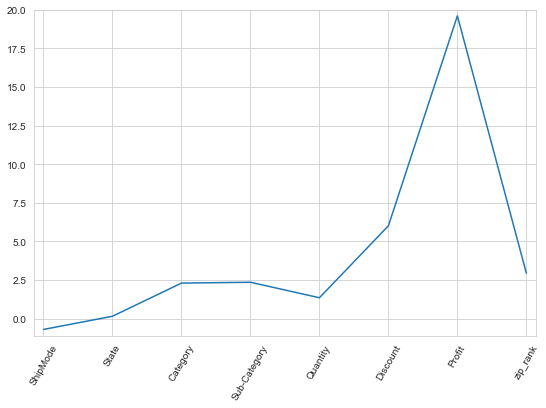

In [31]:
# Plot the coefficients
plt.figure(figsize=(9,6))
plt.plot(range(len(mlr.coef_)), mlr.coef_)
plt.xticks(range(len(mlr.coef_)), features, rotation=60)
plt.margins(0.02)
plt.savefig('images/features.png')
plt.show();

In [32]:
y_pred = mlr.predict(X_test)

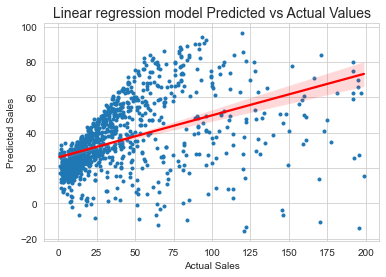

In [33]:
plt.scatter(y_test, y_pred, marker='.', linestyle='None')
sns.regplot(data=df, x=y_test, y=y_pred, scatter=False, color='red')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear regression model Predicted vs Actual Values', fontdict={'fontsize': 14})
plt.savefig('images/lr.png')

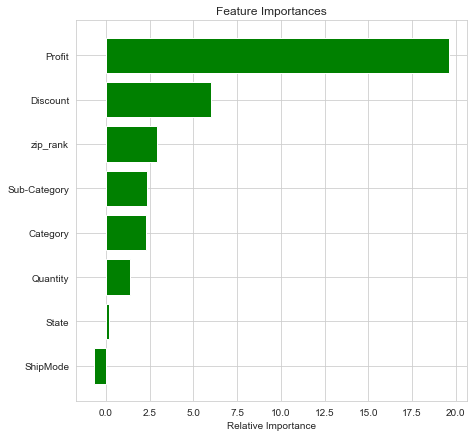

In [34]:
# top important features 
importances = mlr.coef_

indices = np.argsort(importances)[-10:] 
plt.figure(figsize=(7,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

** Top Predictors:**
    - Profit
    - Quantity
    - Discount
    - Postal code
    - Sub_category
    - Category    

#### What Log Transformations Really Mean?

A log-transformed dependent variable implies the linear model has been exponentiated. From the product rule of exponents:
y=exp(β0)exp(β1x)
 
This further implies that the independent variable has a multiplicative relationship with the dependent variable instead of the usual additive relationship. 

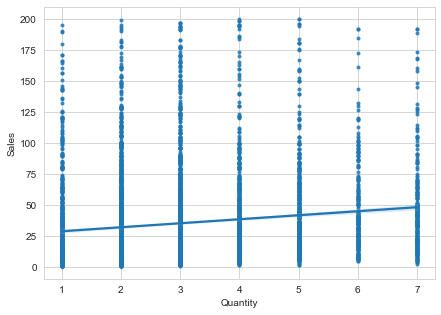

In [35]:
plt.figure(figsize=(7,5))
sns.regplot(x='Quantity', y='Sales', data=df, marker='.');

#### Interpreting coefficients

In [36]:
# how to interpret the 1 unit change of x on y?
np.exp(3) * np.exp(-0.25 * 1)

15.642631884188171

### Ordinary Least Squares (OLS)

In [37]:
# Profit', 

X = df.drop(['log_sales', 'Sales', 'Year','Segment', 'City', 'Region',  'Months'], axis=1)

X = sm.add_constant(X)
y = df['Sales']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

features = X_train.columns
features

Index(['const', 'ShipMode', 'State', 'Category', 'Sub-Category', 'Quantity',
       'Discount', 'Profit', 'zip_rank'],
      dtype='object')

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
# create the third model, it is the same algorithm, just different inputs
olsmod = sm.OLS(y_train, X_train).fit()

# Evaluate the model
print(olsmod.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Sales   R-squared (uncentered):                   0.136
Model:                            OLS   Adj. R-squared (uncentered):              0.134
Method:                 Least Squares   F-statistic:                              80.38
Date:                Fri, 10 Jun 2022   Prob (F-statistic):                   7.13e-124
Time:                        16:44:09   Log-Likelihood:                         -21653.
No. Observations:                4106   AIC:                                  4.332e+04
Df Residuals:                    4098   BIC:                                  4.337e+04
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [40]:
print('F-statistic:', olsmod.fvalue)
print('Probability of observing value at least as high as F-statistic:', olsmod.f_pvalue)

F-statistic: 80.38051776582735
Probability of observing value at least as high as F-statistic: 7.12873774088209e-124


In [41]:
y_pred = olsmod.predict(X_test)

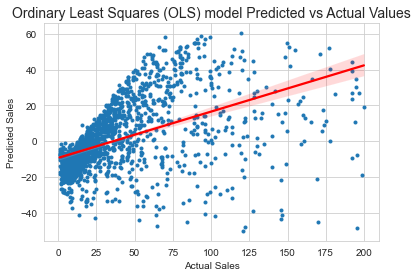

In [42]:
plt.scatter(y_test, y_pred, marker='.', linestyle='None')
sns.regplot(data=df, x=y_test, y=y_pred, scatter=False, color='red')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Ordinary Least Squares (OLS) model Predicted vs Actual Values', fontdict={'fontsize': 14});

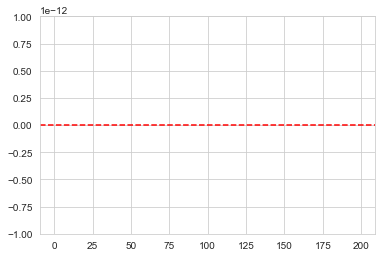

In [43]:
residuals = df.Sales - np.exp(olsmod.predict(X))
plt.scatter(df.Sales, residuals, marker='.')
plt.axhline(y=0, linestyle='--', color='red');
plt.savefig('images/residuals.png')

In [44]:
comp_df = pd.DataFrame(y_test)
comp_df['y_pred'] = y_pred
comp_df.head()

,Sales,y_pred
1527,14.940,-0.721158
589,151.720,42.296090
202,12.960,-17.003044
442,11.360,-6.866555
1276,16.688,-1.299329


In [45]:
def check_RMSE(test, test_pred):    
    return np.sqrt(mean_squared_error(test, test_pred))

print(check_RMSE(comp_df['Sales'], comp_df['y_pred']))

48.53214116793924


### Lasso L1 Norm Regression

AIC alpha: 0.0
BIC alpha: 0.0035


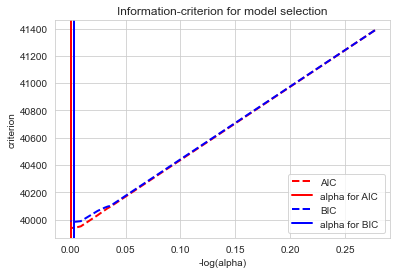

In [46]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.alpha_
print("AIC alpha:", round(model_aic.alpha_, 4))

model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(X_train, y_train)
alpha_bic_ = model_bic.alpha_
print("BIC alpha:", round(model_bic.alpha_,4))


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot((alphas_), criterion_, '--', color=color, linewidth=2, label= name)
    plt.axvline((alpha_), color=color, linewidth=2,
                label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'red')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title('Information-criterion for model selection');

In [47]:
# lassoCV = LassoCV(max_iter=1000, cv=5)
lassocv = LassoCV(alphas=None, cv=15, max_iter=100000, normalize=True)
lassocv.fit(X_train, y_train)
print('The optimal alpha for the Lasso Regression is: ', lassocv.alpha_)

The optimal alpha for the Lasso Regression is:  0.0008453614421784017


In [48]:
make_model(lassocv, X_train, X_test, y_train, y_test, 'Lasso')

R2:  26.11 
MAE:  20.81 
RMSE:  32.1 
9 predictors used for this model


In [49]:
# the 5th coeffcient of 'State' is shrinked to 0 - 
lasso_intercept = lassocv.intercept_
lasso_coef = lassocv.coef_

print(lasso_intercept, lasso_coef)

35.36677691183634 [ 0.         -0.54626732  0.14446087  2.02630435  2.36893516  1.24076275
  6.00196005 19.42090587  2.92764367]


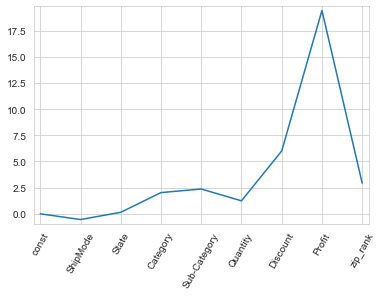

In [50]:
# Plot the coefficients
plt.plot(range(len(lasso_coef)), lasso_coef)
plt.xticks(range(len(lasso_coef)), features, rotation=60)
plt.margins(0.02)
plt.show();
# the most important predictor for the target varaible is "discount"?
# this is a type of feature selection very important for machine learning in a business

### Ridge L2 norm regression

In [51]:
# losss function = standard OLS loss function + squared value of each coefficient mulitplied with some constant alpha/lambda - controls model complexity
# when minimizing tthe losss function to fit to data, the model is penalized for large coeeficient of large magnitude
# alphas = np.logspace(-4, 0, 50)
alphas = 10**np.linspace(10,-2,100)*0.5
ridgecv = RidgeCV(alphas=alphas, normalize=True)
ridgecv.fit(X_train, y_train)

ridge = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge.fit(X_train, y_train)

Ridge(alpha=0.005, normalize=True)

In [52]:
# large aplaph means the large coefficients are significantly penalized
ridge_scores = []
ridge_scores_std = []

In [53]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alphas, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alphas, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

In [54]:
make_model(ridge, X_train, X_test, y_train, y_test, 'Ridge')

R2:  26.11 
MAE:  20.81 
RMSE:  32.11 
9 predictors used for this model


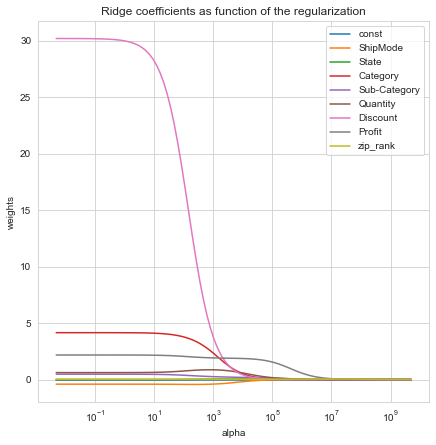

In [55]:
w = list()
for a in alphas:
    ridge_clf = RidgeCV(alphas=[a],cv=10).fit(X, y)
    w.append(ridge_clf.coef_)

w = np.array(w)

plt.figure(figsize=(7,7))
plt.semilogx(alphas,w)
plt.title('Ridge coefficients as function of the regularization')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.legend(X.keys())
plt.show();

Both lasso and ridge regression show alpha is close to 0 which indicates regression is back to the standard OLS regression, no over-fitting is accounted for.
Setting 'normalized = true' ensures that all variables are on the same scale.

### Random Forest Regressor

In [56]:
X = df.drop(['log_sales', 'Sales', 'Year','Segment', 'City', 'Region',  'Months'], axis=1)
y = df['Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
print(X_train.shape, X_test.shape)

(4693, 8) (1174, 8)


In [57]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [58]:
 #rfr = RandomForestRegressor(n_estimators=50, min_samples_split=2, random_state=42)
 #rfr.fit(X_train, y_train)

In [59]:
rfr = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_depth=10, n_estimators=500, random_state=42)

In [60]:
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    from sklearn.metrics import r2_score
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

In [61]:
make_model(rfr, X_train, X_test, y_train, y_test, 'rfr')

R2:  75.15 
MAE:  9.59 
RMSE:  19.62 
8 predictors used for this model


In [62]:
models

{'Models': ['Linear regression', 'Lasso', 'Ridge', 'rfr'],
 'r2': [26.71, 26.11, 26.11, 75.15],
 'mae': [21.2, 20.81, 20.81, 9.59],
 'rmse': [33.26, 32.1, 32.11, 19.62]}

In [63]:
pd.DataFrame(models)

,Models,r2,mae,rmse
0,Linear regression,26.71,21.20,33.26
1,Lasso,26.11,20.81,32.10
2,Ridge,26.11,20.81,32.11
3,rfr,75.15,9.59,19.62


The results show that the best performances in terms of R squared (R²) and Root Mean Square Error (RMSE) correspond to random forest Regressor.

According to the result of R² and Root Mean Squared of these 5 models, the relationship between the features and the target variable is not clearly linear and shows the presence of non-linearity in the data.

## Summary and further analysis

Since the data was collected from 2014-2018, this model might not fully reflect all the price changes recently in the market. Moreover, features that were used in developing this algorithm, might not be enough to sufficiently describe the sales. The sales range is mainly less than ~$100, which is a bit small in my opinion.

And lastly, the market of densely populated urban areas is definitely different from that of the rural area. This means more data needs to be collected for different regions across all 49 states in US in order to efficiently predict the sales for any particular area.

The final data sets include:

X_train, X_test - train/test split predictors for label encoded sets
y_train, y_test - target values for all sets
